## My own version of the LSTM BaseLine

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score, mean_absolute_error

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter

**Note :** Just to have a normalized methodology to save and visualize the results of all the experiments trought this projet I add and configure a Tensorboard-SummaryWriter. In the same way I have changed the training cycle to put the results in the tensorboard format.

In [6]:
writer = SummaryWriter('../logs/my_Hybrid_2')

## Importing the data in a unique dictionary

In [7]:
filesList = os.listdir('../src')
print(filesList)

['soil_data.csv', 'train_timeseries', 'counties.geojson', 'test_timeseries', 'validation_timeseries', 'counties.zip']


In [8]:
dataDic = {"train": pd.read_csv("../src/train_timeseries/train_timeseries.csv"),
           "test": pd.read_csv("../src/test_timeseries/test_timeseries.csv"),
           "validation": pd.read_csv("../src/validation_timeseries/validation_timeseries.csv"),
           "soil" : pd.read_csv("../src/soil_data.csv"),
           }


In [9]:
dataDic["train"].columns

Index(['fips', 'date', 'PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET',
       'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX',
       'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN',
       'WS50M_RANGE', 'score'],
      dtype='object')

In [10]:
class2id = {
    'None': 0,
    'D0': 1,
    'D1': 2,
    'D2': 3,
    'D3': 4,
    'D4': 5,
}
id2class = {v: k for k, v in class2id.items()}

In [11]:
dfs = {
    k: dataDic[k].set_index(['fips', 'date'])
    for k in dataDic.keys() if k != "soil"
}

dfs["soil"] = dataDic["soil"]

In [12]:
# dfs["train"]

## Interpolation pour les données manquantes

In [13]:
def interpolate_nans(padata, pkind='linear'):
    """
    see: https://stackoverflow.com/a/53050216/2167159
    """
    aindexes = np.arange(padata.shape[0])
    agood_indexes, = np.where(np.isfinite(padata))
    f = interp1d(agood_indexes
               , padata[agood_indexes]
               , bounds_error=False
               , copy=False
               , fill_value="extrapolate"
               , kind=pkind)
    return f(aindexes)

## Function to encode the cycling feature: year-day, using sin/cos

In [14]:
def date_encode(date):
    if isinstance(date, str):
        date = datetime.strptime(date, "%Y-%m-%d")
    return (
        np.sin(2 * np.pi * date.timetuple().tm_yday / 366),
        np.cos(2 * np.pi * date.timetuple().tm_yday / 366),
    )

## Function to load the data

In [15]:
def loadXY(
    df,
    random_state=42,
    window_size=180, # how many days in the past (default/competition: 180)
    target_size=6, # how many weeks into the future (default/competition: 6)
    fuse_past=True, # add the past drought observations? (default: True)
    return_fips=False, # return the county identifier (do not use for predictions)
    encode_season=True, # encode the season using the function above (default: True) 
    use_prev_year=False, # add observations from 1 year prior?
):
    df = dfs[df]
    soil_df = dfs["soil"]
    time_data_cols = sorted(
        [c for c in df.columns if c not in ["fips", "date", "score"]]
    )
    static_data_cols = sorted(
        [c for c in soil_df.columns if c not in ["soil", "lat", "lon"]]
    )
    count = 0
    score_df = df.dropna(subset=["score"])
    X_static = np.empty((len(df) // window_size, len(static_data_cols)))
    X_fips_date = []
    add_dim = 0
    if use_prev_year:
        add_dim += len(time_data_cols)
    if fuse_past:
        add_dim += 1
        if use_prev_year:
            add_dim += 1
    if encode_season:
        add_dim += 2
    X_time = np.empty(
        (len(df) // window_size, window_size, len(time_data_cols) + add_dim)
    )
    y_past = np.empty((len(df) // window_size, window_size))
    y_target = np.empty((len(df) // window_size, target_size))
    if random_state is not None:
        np.random.seed(random_state)
    for fips in tqdm(score_df.index.get_level_values(0).unique()):
        if random_state is not None:
            start_i = np.random.randint(1, window_size)
        else:
            start_i = 1
        fips_df = df[(df.index.get_level_values(0) == fips)]
        X = fips_df[time_data_cols].values
        y = fips_df["score"].values
        X_s = soil_df[soil_df["fips"] == fips][static_data_cols].values[0]
        for i in range(start_i, len(y) - (window_size + target_size * 7), window_size):
            X_fips_date.append((fips, fips_df.index[i : i + window_size][-1]))
            X_time[count, :, : len(time_data_cols)] = X[i : i + window_size]
            if use_prev_year:
                if i < 365 or len(X[i - 365 : i + window_size - 365]) < window_size:
                    continue
                X_time[count, :, -len(time_data_cols) :] = X[
                    i - 365 : i + window_size - 365
                ]
            if not fuse_past:
                y_past[count] = interpolate_nans(y[i : i + window_size])
            else:
                X_time[count, :, len(time_data_cols)] = interpolate_nans(
                    y[i : i + window_size]
                )
            if encode_season:
                enc_dates = [
                    date_encode(d) for f, d in fips_df.index[i : i + window_size].values
                ]
                d_sin, d_cos = [s for s, c in enc_dates], [c for s, c in enc_dates]
                X_time[count, :, len(time_data_cols) + (add_dim - 2)] = d_sin
                X_time[count, :, len(time_data_cols) + (add_dim - 2) + 1] = d_cos
            temp_y = y[i + window_size : i + window_size + target_size * 7]
            y_target[count] = np.array(temp_y[~np.isnan(temp_y)][:target_size])
            X_static[count] = X_s
            count += 1
    print(f"loaded {count} samples")
    results = [X_static[:count], X_time[:count], y_target[:count]]
    if not fuse_past:
        results.append(y_past[:count])
    if return_fips:
        results.append(X_fips_date)
    return results

In [16]:
scaler_dict = {}
scaler_dict_static = {}
scaler_dict_past = {}


def normalize(X_static, X_time, y_past=None, fit=False):
    for index in tqdm(range(X_time.shape[-1])):
        if fit:
            scaler_dict[index] = RobustScaler().fit(X_time[:, :, index].reshape(-1, 1))
        X_time[:, :, index] = (
            scaler_dict[index]
            .transform(X_time[:, :, index].reshape(-1, 1))
            .reshape(-1, X_time.shape[-2])
        )
    for index in tqdm(range(X_static.shape[-1])):
        if fit:
            scaler_dict_static[index] = RobustScaler().fit(
                X_static[:, index].reshape(-1, 1)
            )
        X_static[:, index] = (
            scaler_dict_static[index]
            .transform(X_static[:, index].reshape(-1, 1))
            .reshape(1, -1)
        )
    index = 0
    if y_past is not None:
        if fit:
            scaler_dict_past[index] = RobustScaler().fit(y_past.reshape(-1, 1))
        y_past[:, :] = (
            scaler_dict_past[index]
            .transform(y_past.reshape(-1, 1))
            .reshape(-1, y_past.shape[-1])
        )
        return X_static, X_time, y_past
    return X_static, X_time

In [17]:
# X_tabular_train, X_time_train, y_target_train = loadXY("train", use_prev_year=True)
# print("train shape", X_time_train.shape)
# X_tabular_validation, X_time_valid, y_target_valid, valid_fips = loadXY("validation", return_fips=True, use_prev_year=True)
# print("validation shape", X_time_valid.shape)
# X_tabular_test, X_time_test, y_target_test, test_fips = loadXY("test", return_fips=True, use_prev_year=True)
# print("test shape", X_time_test.shape)
# X_tabular_train, X_time_train = normalize(X_tabular_train, X_time_train, fit=True)
# X_tabular_validation, X_time_valid = normalize(X_tabular_validation, X_time_valid)
# X_tabular_test, X_time_test = normalize(X_tabular_test, X_time_test)

In [18]:
# # export all
# import pickle
# np.save("../data/processed_no_cat_and_no_tensors/X_tabular_train.npy", X_tabular_train)
# np.save("../data/processed_no_cat_and_no_tensors/X_time_train.npy", X_time_train)
# np.save("../data/processed_no_cat_and_no_tensors/y_target_train.npy", y_target_train)
# np.save("../data/processed_no_cat_and_no_tensors/X_tabular_validation.npy", X_tabular_validation)
# np.save("../data/processed_no_cat_and_no_tensors/X_time_valid.npy", X_time_valid)
# np.save("../data/processed_no_cat_and_no_tensors/y_target_valid.npy", y_target_valid)
# np.save("../data/processed_no_cat_and_no_tensors/X_tabular_test.npy", X_tabular_test)
# np.save("../data/processed_no_cat_and_no_tensors/X_time_test.npy", X_time_test)
# np.save("../data/processed_no_cat_and_no_tensors/y_target_test.npy", y_target_test)
# with open(f"../data/processed_no_cat_and_no_tensors/valid_fips.pickle", "wb") as f:
#     pickle.dump(valid_fips, f)
# with open(f"../data/processed_no_cat_and_no_tensors/test_fips.pickle", "wb") as f:
#     pickle.dump(test_fips, f)

In [19]:
# # import all
# import pickle
# # import all
# X_tabular_train = np.load("../data/processed_no_cat_and_no_tensors/X_tabular_train.npy")
# X_time_train = np.load("../data/processed_no_cat_and_no_tensors/X_time_train.npy")
# y_target_train = np.load("../data/processed_no_cat_and_no_tensors/y_target_train.npy")
# X_tabular_validation = np.load("../data/processed_no_cat_and_no_tensors/X_tabular_validation.npy")
# X_time_valid = np.load("../data/processed_no_cat_and_no_tensors/X_time_valid.npy")
# y_target_valid = np.load("../data/processed_no_cat_and_no_tensors/y_target_valid.npy")
# X_tabular_test = np.load("../data/processed_no_cat_and_no_tensors/X_tabular_test.npy")
# X_time_test = np.load("../data/processed_no_cat_and_no_tensors/X_time_test.npy")
# y_target_test = np.load("../data/processed_no_cat_and_no_tensors/y_target_test.npy")
# with open(f"../data/processed_no_cat_and_no_tensors/valid_fips.pickle", "rb") as f:
#     valid_fips = pickle.load(f)
# with open(f"../data/processed_no_cat_and_no_tensors/test_fips.pickle", "rb") as f:
#     test_fips = pickle.load(f)


In [20]:
# import
import pickle
with open("../data/data.pkl", "rb") as f:
    data = pickle.load(f)
    X_tabular_train = data["X_tabular_train"]
    X_time_train = data["X_time_train"]
    y_target_train = data["y_target_train"]
    X_tabular_validation = data["X_tabular_validation"]
    X_time_valid = data["X_time_valid"]
    y_target_valid = data["y_target_valid"]
    valid_fips = data["valid_fips"]
    X_tabular_test = data["X_tabular_test"]
    X_time_test = data["X_time_test"]
    y_target_test = data["y_target_test"]
    test_fips = data["test_fips"]


In [31]:
start, end = (4001, 4027)

In [32]:
np.where((X_tabular_train[:,21] >= start) & (X_tabular_train[:,21] <= end))

(array([2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099,
        2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110,
        2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121,
        2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132,
        2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143,
        2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154,
        2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165,
        2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176,
        2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187,
        2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198,
        2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209,
        2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220,
        2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231,
        2232, 2233, 2234, 2235, 2236, 

In [33]:
np.where((X_tabular_validation[:,21] >= start) & (X_tabular_validation[:,21] <= end))

(array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]),)

In [34]:
np.where((X_tabular_test[:,21] >= start) & (X_tabular_test[:,21] <= end))

(array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]),)

In [298]:
ordered_cols = sorted([c for c in dfs["soil"].columns if c not in ["soil", "lat", "lon"]])
# cat_cols = [ordered_cols.index(i) for i in ["fips", "SQ1", "SQ2", "SQ3", "SQ4", "SQ5", "SQ6", "SQ7"]]
cat_cols = [ordered_cols.index(i) for i in ["SQ1", "SQ2", "SQ3", "SQ4", "SQ5", "SQ6", "SQ7"]]

In [299]:
X_tabular_cat_train = X_tabular_train[:,cat_cols].astype(int)
X_tabular_train = X_tabular_train[:,[i for i in range(X_tabular_train.shape[1]) if i not in cat_cols]]

X_tabular_cat_valid = X_tabular_validation[:,cat_cols].astype(int)
X_tabular_validation = X_tabular_validation[:,[i for i in range(X_tabular_validation.shape[1]) if i not in cat_cols]]

X_tabular_cat_test = X_tabular_test[:,cat_cols].astype(int)
X_tabular_test = X_tabular_test[:,[i for i in range(X_tabular_test.shape[1]) if i not in cat_cols]]

In [300]:
dico_trad = {}
for cat in range(X_tabular_cat_train.shape[1]):
    dico_trad[cat] = {j: i for i,j in enumerate(sorted(np.unique_values(X_tabular_cat_train[:,cat])))}
    dico_trad[cat]["unknown"] = len(np.unique_values(X_tabular_cat_train[:,cat]))

In [301]:
dico_trad[0]

{np.int64(0): 0,
 np.int64(1): 1,
 np.int64(2): 2,
 np.int64(3): 3,
 np.int64(4): 4,
 np.int64(6): 5,
 np.int64(7): 6,
 'unknown': 7}

In [302]:
for cat in range(len(cat_cols)):
    X_tabular_cat_train[:,cat] = [dico_trad[cat][i] for i in X_tabular_cat_train[:,cat]]
    X_tabular_cat_valid[:,cat] = [dico_trad[cat][i] if i in dico_trad[cat] else dico_trad[cat]["unknown"] for i in X_tabular_cat_valid[:,cat]]
    X_tabular_cat_test[:,cat] = [dico_trad[cat][i] if i in dico_trad[cat] else dico_trad[cat]["unknown"] for i in X_tabular_cat_test[:,cat]]

In [281]:
np.sort(X_tabular_train[:,14])

array([19001., 19001., 19001., ..., 19197., 19197., 19197.])

In [253]:
X_tabular_train.shape

(3094, 23)

In [25]:
X_tabular_train, X_time_train = normalize(X_tabular_train, X_time_train, fit=True)
X_tabular_validation, X_time_valid = normalize(X_tabular_validation, X_time_valid)
X_tabular_test, X_time_test = normalize(X_tabular_test, X_time_test)

100%|██████████| 23/23 [00:00<00:00, 10245.22it/s]


In [26]:
X_time_train.shape

(97099, 180, 40)

In [27]:
X_time_test.shape

(2477, 180, 40)

In [28]:
X_time_valid.shape

(2457, 180, 40)

In [29]:
X_tabular_train.shape

(97099, 23)

In [30]:
X_tabular_cat_train.shape

(97099, 7)

In [31]:
batch_size = 128
output_weeks = 6
hidden_dim = 490
n_layers = 2
ffnn_layers = 2
dropout = 0.1
lr = 7e-5
epochs = 9
clip = 5
embed_dim = [3, 3, 3, 3, 3, 3, 3]
embed_dropout = 0.4

In [32]:
#  Prepare the datasets
train_data = TensorDataset(
    torch.tensor(X_time_train),
    torch.tensor(X_tabular_train),
    torch.tensor(X_tabular_cat_train),
    torch.tensor(y_target_train[:, :output_weeks]),
)
valid_data = TensorDataset(
    torch.tensor(X_time_valid),
    torch.tensor(X_tabular_validation),
    torch.tensor(X_tabular_cat_valid),
    torch.tensor(y_target_valid[:, :output_weeks]),
)

# DataLoaders with sampler for training and default for validation
train_loader = DataLoader(
    train_data, batch_size=batch_size, drop_last=False
)

valid_loader = DataLoader(
    valid_data, shuffle=False, batch_size=batch_size, drop_last=False
)

test_data = TensorDataset(
    torch.tensor(X_time_test),
    torch.tensor(X_tabular_test),
    torch.tensor(X_tabular_cat_test),
    torch.tensor(y_target_test[:, :output_weeks]),
)

test_loader = DataLoader(
    test_data, shuffle=False, batch_size=batch_size, drop_last=False
)

In [33]:
next(iter(test_loader))[2]

tensor([[1, 1, 1, 1, 1, 1, 2],
        [3, 2, 1, 2, 1, 1, 1],
        [3, 2, 1, 1, 1, 1, 1],
        [3, 2, 1, 1, 1, 1, 1],
        [3, 2, 1, 1, 1, 1, 1],
        [3, 2, 1, 1, 1, 1, 1],
        [3, 2, 1, 2, 1, 1, 1],
        [3, 2, 1, 1, 1, 1, 1],
        [3, 2, 1, 1, 1, 1, 1],
        [3, 2, 1, 1, 1, 1, 1],
        [3, 2, 1, 1, 1, 1, 1],
        [3, 2, 1, 2, 1, 1, 1],
        [3, 2, 1, 1, 1, 1, 1],
        [3, 2, 1, 1, 1, 1, 1],
        [3, 2, 1, 1, 1, 1, 1],
        [3, 2, 1, 1, 1, 1, 1],
        [3, 2, 1, 1, 1, 1, 1],
        [3, 2, 1, 1, 1, 1, 1],
        [3, 2, 1, 1, 1, 1, 1],
        [3, 2, 1, 1, 1, 1, 1],
        [3, 2, 1, 1, 1, 1, 1],
        [3, 2, 1, 1, 1, 1, 1],
        [3, 2, 1, 1, 1, 1, 1],
        [3, 2, 1, 1, 1, 1, 1],
        [3, 2, 1, 1, 1, 1, 1],
        [2, 2, 1, 1, 1, 1, 1],
        [3, 2, 1, 1, 1, 1, 1],
        [3, 2, 1, 1, 1, 1, 1],
        [4, 3, 2, 2, 2, 2, 2],
        [3, 2, 1, 1, 1, 1, 1],
        [3, 2, 1, 1, 1, 1, 1],
        [6, 6, 6, 6, 6, 5, 7],
        

In [34]:
list_cat = [len(np.unique(X_tabular_cat_train[:,i])) + 1 for i in range(X_tabular_cat_train.shape[1])]

In [35]:
list_cat

[8, 8, 8, 8, 8, 7, 9]

In [36]:
class DroughtNetLSTM(nn.Module):
    def __init__(
        self,
        output_size,
        num_input_features,
        hidden_dim,
        n_layers,
        ffnn_layers,
        drop_prob,
        static_dim,
        list_unic_cat,
        embedding_dims,
        embeddings_dropout,
    ):
        super(DroughtNetLSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim


        self.embeddings = nn.ModuleList(
                [
                    nn.Embedding(num_embeddings=i, embedding_dim=dimension)
                    for i, dimension in zip(list_unic_cat, embedding_dims)
                ]
            )
        self.embeddings_dropout = nn.Dropout(embeddings_dropout)
        self.after_embeddings = nn.Sequential(nn.Linear(sum(embedding_dims), 7), nn.ReLU())

        self.lstm = nn.LSTM(
            num_input_features,
            hidden_dim,
            n_layers,
            dropout=drop_prob,
            batch_first=True,
        )
        self.attention = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(drop_prob)
        self.fflayers = []
        for i in range(ffnn_layers - 1):
            if i == 0:
                self.fflayers.append(nn.Linear(hidden_dim*2 + static_dim + 7, hidden_dim))
            else:
                self.fflayers.append(nn.Linear(hidden_dim, hidden_dim))
        self.fflayers = nn.ModuleList(self.fflayers)
        self.final = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden, static, cat):
        batch_size = x.size(0)
        x = x.to(dtype=torch.float32)
        static = static.to(dtype=torch.float32)
        lstm_out, hidden = self.lstm(x, hidden)
        last_hidden = lstm_out[:, -1, :]
        attn_weights = F.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attn_weights * lstm_out, dim=1)
        att_out = torch.cat((context_vector, last_hidden), 1)
        out = self.dropout(att_out)

        embeddings = [emb(cat[:, i]) for i, emb in enumerate(self.embeddings)]
        cat = torch.cat(embeddings, dim=1)
        cat = self.embeddings_dropout(cat)
        cat = self.after_embeddings(cat)
        
        for i in range(len(self.fflayers)):
            if i == 0 and static is not None:
                out = self.fflayers[i](torch.cat((out, static, cat), 1))
            else:
                out = self.fflayers[i](out)
        out = self.final(out)

        out = out.view(batch_size, -1)
        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
        )
        return hidden

In [37]:
static_dim = X_tabular_train.shape[-1]

In [108]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("using GPU")
else:
    device = torch.device("cpu")
    print("using CPU")
static_dim = 0

static_dim = X_tabular_train.shape[-1]
model = DroughtNetLSTM(
    output_weeks,
    X_time_train.shape[-1],
    hidden_dim,
    n_layers,
    ffnn_layers,
    dropout,
    static_dim,
    list_cat,
    embed_dim,
    embed_dropout,
)
model.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs
)
counter = 0
valid_loss_min = np.inf
torch.manual_seed(42)
np.random.seed(42)
for i in range(epochs):
    h = model.init_hidden(batch_size)

    for k, (inputs, static, cat ,labels) in tqdm(
        enumerate(train_loader),
        desc=f"epoch {i+1}/{epochs}",
        total=len(train_loader),
    ):
        model.train()
        counter += 1
        if len(inputs) < batch_size:
            h = model.init_hidden(len(inputs))
        h = tuple([e.data for e in h])
        inputs, labels, static, cat = (
            inputs.to(device),
            labels.to(device),
            static.to(device),
            cat.to(device),
        )
        model.zero_grad()
        output, h = model(inputs, h, static, cat)
        loss = loss_function(output, labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        scheduler.step()

        with torch.no_grad():
            if k == len(train_loader) - 1 or k == (len(train_loader) - 1) // 2:
                val_h = model.init_hidden(batch_size)
                val_losses = []
                model.eval()
                labels = []
                preds = []
                raw_labels = []
                raw_preds = []
                for inp, stat, cat, lab in valid_loader:
                    if len(inp) < batch_size:
                        val_h = model.init_hidden(len(inp))
                    val_h = tuple([each.data for each in val_h])
                    inp, lab, stat, cat = inp.to(device), lab.to(device), stat.to(device), cat.to(device)
                    out, val_h = model(inp, val_h, stat, cat)
                    val_loss = loss_function(out, lab.float())
                    val_losses.append(val_loss.item())
                    for labs in lab:
                        labels.append([int(l.round()) for l in labs])
                        raw_labels.append([float(l) for l in labs])
                    for pred in out:
                        preds.append([int(p.round()) for p in pred])
                        raw_preds.append([float(p) for p in pred])
                # log data
                labels = np.array(labels)
                preds = np.clip(np.array(preds), 0, 5)
                raw_preds = np.array(raw_preds)
                raw_labels = np.array(raw_labels)
                for i in range(output_weeks):
                    log_dict = {
                        "loss": float(loss),
                        "epoch": counter / len(train_loader),
                        "step": counter,
                        "lr": optimizer.param_groups[0]["lr"],
                        "week": i + 1,
                    }
                    # w = f'week_{i+1}_'
                    w = ""
                    log_dict[f"{w}validation_loss"] = np.mean(val_losses)
                    log_dict[f"{w}macro_f1"] = f1_score(
                        labels[:, i], preds[:, i], average="macro"
                    )
                    log_dict[f"{w}micro_f1"] = f1_score(
                        labels[:, i], preds[:, i], average="micro"
                    )
                    log_dict[f"{w}mae"] = mean_absolute_error(
                        raw_labels[:, i], raw_preds[:, i]
                    )
                    print(log_dict)
                    writer.add_scalars("Loss(MSE)", {'train': loss,
                                                     'validation': log_dict[f"{w}validation_loss"]},
                                                     counter)
                    writer.add_scalars("F1(MSE)", {'macro': log_dict[f"{w}macro_f1"],
                                                   'micro': log_dict[f"{w}micro_f1"]},
                                                   counter)
                    writer.add_scalar("MAE", log_dict[f"{w}mae"],
                                      counter)
                    writer.add_scalar("Learning-Rate", log_dict["lr"],
                                      counter)
                    for j, f1 in enumerate(
                        f1_score(labels[:, i], preds[:, i], average=None)
                    ):
                        log_dict[f"{w}{id2class[j]}_f1"] = f1
                    model.train()
                if np.mean(val_losses) <= valid_loss_min:
                    torch.save(model.state_dict(), "./my_Hybrid.pt")
                    print(
                        "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                            valid_loss_min, np.mean(val_losses)
                        )
                    )
                    valid_loss_min = np.mean(val_losses)

using GPU


epoch 1/9:  50%|█████     | 380/759 [01:55<08:35,  1.36s/it]

{'loss': 0.7313270568847656, 'epoch': 0.5006587615283268, 'step': 380, 'lr': 8.347028457168662e-06, 'week': 1, 'validation_loss': np.float64(0.9253082752227784), 'macro_f1': np.float64(0.07619957534681741), 'micro_f1': np.float64(0.17216117216117216), 'mae': np.float64(0.787826975488585)}
{'loss': 0.7313270568847656, 'epoch': 0.5006587615283268, 'step': 380, 'lr': 8.347028457168662e-06, 'week': 2, 'validation_loss': np.float64(0.9253082752227784), 'macro_f1': np.float64(0.09454909024857348), 'micro_f1': np.float64(0.1908831908831909), 'mae': np.float64(0.8168768943491242)}
{'loss': 0.7313270568847656, 'epoch': 0.5006587615283268, 'step': 380, 'lr': 8.347028457168662e-06, 'week': 3, 'validation_loss': np.float64(0.9253082752227784), 'macro_f1': np.float64(0.07313525933683014), 'micro_f1': np.float64(0.1693121693121693), 'mae': np.float64(0.8123849290752779)}
{'loss': 0.7313270568847656, 'epoch': 0.5006587615283268, 'step': 380, 'lr': 8.347028457168662e-06, 'week': 4, 'validation_loss': 

epoch 1/9: 100%|██████████| 759/759 [03:52<00:00,  3.27it/s]


{'loss': 0.2405368536710739, 'epoch': 1.0, 'step': 759, 'lr': 2.3109247762016332e-05, 'week': 1, 'validation_loss': np.float64(0.21882819049060345), 'macro_f1': np.float64(0.6396337747323771), 'micro_f1': np.float64(0.8583638583638583), 'mae': np.float64(0.24087394901668222)}
{'loss': 0.2405368536710739, 'epoch': 1.0, 'step': 759, 'lr': 2.3109247762016332e-05, 'week': 2, 'validation_loss': np.float64(0.21882819049060345), 'macro_f1': np.float64(0.5535114650149088), 'micro_f1': np.float64(0.8237688237688238), 'mae': np.float64(0.28037126361851683)}
{'loss': 0.2405368536710739, 'epoch': 1.0, 'step': 759, 'lr': 2.3109247762016332e-05, 'week': 3, 'validation_loss': np.float64(0.21882819049060345), 'macro_f1': np.float64(0.5063629229021466), 'micro_f1': np.float64(0.8038258038258038), 'mae': np.float64(0.30506294118542043)}
{'loss': 0.2405368536710739, 'epoch': 1.0, 'step': 759, 'lr': 2.3109247762016332e-05, 'week': 4, 'validation_loss': np.float64(0.21882819049060345), 'macro_f1': np.float

epoch 2/9:  50%|█████     | 380/759 [01:57<08:36,  1.36s/it]

{'loss': 0.24781768023967743, 'epoch': 1.5006587615283267, 'step': 1139, 'lr': 4.228814190083561e-05, 'week': 1, 'validation_loss': np.float64(0.18462276197969912), 'macro_f1': np.float64(0.6826147933014933), 'micro_f1': np.float64(0.8909238909238909), 'mae': np.float64(0.20712213025281084)}
{'loss': 0.24781768023967743, 'epoch': 1.5006587615283267, 'step': 1139, 'lr': 4.228814190083561e-05, 'week': 2, 'validation_loss': np.float64(0.18462276197969912), 'macro_f1': np.float64(0.6150205805470873), 'micro_f1': np.float64(0.8587708587708588), 'mae': np.float64(0.23976763330705717)}
{'loss': 0.24781768023967743, 'epoch': 1.5006587615283267, 'step': 1139, 'lr': 4.228814190083561e-05, 'week': 3, 'validation_loss': np.float64(0.18462276197969912), 'macro_f1': np.float64(0.5127613827029748), 'micro_f1': np.float64(0.8225478225478225), 'mae': np.float64(0.2750839935588822)}
{'loss': 0.24781768023967743, 'epoch': 1.5006587615283267, 'step': 1139, 'lr': 4.228814190083561e-05, 'week': 4, 'validati

epoch 2/9: 100%|██████████| 759/759 [03:54<00:00,  3.23it/s]


{'loss': 0.15813010931015015, 'epoch': 2.0, 'step': 1518, 'lr': 5.9485470532650715e-05, 'week': 1, 'validation_loss': np.float64(0.18024117462337017), 'macro_f1': np.float64(0.7400405772250961), 'micro_f1': np.float64(0.901912901912902), 'mae': np.float64(0.16927453617046628)}
{'loss': 0.15813010931015015, 'epoch': 2.0, 'step': 1518, 'lr': 5.9485470532650715e-05, 'week': 2, 'validation_loss': np.float64(0.18024117462337017), 'macro_f1': np.float64(0.6717302811868788), 'micro_f1': np.float64(0.8624338624338624), 'mae': np.float64(0.20947058937232038)}
{'loss': 0.15813010931015015, 'epoch': 2.0, 'step': 1518, 'lr': 5.9485470532650715e-05, 'week': 3, 'validation_loss': np.float64(0.18024117462337017), 'macro_f1': np.float64(0.6247601293181949), 'micro_f1': np.float64(0.8306878306878307), 'mae': np.float64(0.25154475000966725)}
{'loss': 0.15813010931015015, 'epoch': 2.0, 'step': 1518, 'lr': 5.9485470532650715e-05, 'week': 4, 'validation_loss': np.float64(0.18024117462337017), 'macro_f1': n

epoch 3/9:  50%|█████     | 380/759 [01:57<08:33,  1.36s/it]

{'loss': 0.23459181189537048, 'epoch': 2.5006587615283267, 'step': 1898, 'lr': 6.911117601581325e-05, 'week': 1, 'validation_loss': np.float64(0.17682246677577496), 'macro_f1': np.float64(0.6215886913800358), 'micro_f1': np.float64(0.8917378917378918), 'mae': np.float64(0.17010730001850127)}
{'loss': 0.23459181189537048, 'epoch': 2.5006587615283267, 'step': 1898, 'lr': 6.911117601581325e-05, 'week': 2, 'validation_loss': np.float64(0.17682246677577496), 'macro_f1': np.float64(0.5524672923676187), 'micro_f1': np.float64(0.85999185999186), 'mae': np.float64(0.20588197491401136)}
{'loss': 0.23459181189537048, 'epoch': 2.5006587615283267, 'step': 1898, 'lr': 6.911117601581325e-05, 'week': 3, 'validation_loss': np.float64(0.17682246677577496), 'macro_f1': np.float64(0.4505246122933824), 'micro_f1': np.float64(0.8233618233618234), 'mae': np.float64(0.2504076302268012)}
{'loss': 0.23459181189537048, 'epoch': 2.5006587615283267, 'step': 1898, 'lr': 6.911117601581325e-05, 'week': 4, 'validation

epoch 3/9: 100%|██████████| 759/759 [03:54<00:00,  3.24it/s]


{'loss': 0.1347734034061432, 'epoch': 3.0, 'step': 2277, 'lr': 6.960564578189073e-05, 'week': 1, 'validation_loss': np.float64(0.1800047716125846), 'macro_f1': np.float64(0.7482237831566225), 'micro_f1': np.float64(0.8880748880748881), 'mae': np.float64(0.16034488063539534)}
{'loss': 0.1347734034061432, 'epoch': 3.0, 'step': 2277, 'lr': 6.960564578189073e-05, 'week': 2, 'validation_loss': np.float64(0.1800047716125846), 'macro_f1': np.float64(0.7036443683439763), 'micro_f1': np.float64(0.8571428571428571), 'mae': np.float64(0.19718625754743183)}
{'loss': 0.1347734034061432, 'epoch': 3.0, 'step': 2277, 'lr': 6.960564578189073e-05, 'week': 3, 'validation_loss': np.float64(0.1800047716125846), 'macro_f1': np.float64(0.6278226755584909), 'micro_f1': np.float64(0.827024827024827), 'mae': np.float64(0.23854271592243229)}
{'loss': 0.1347734034061432, 'epoch': 3.0, 'step': 2277, 'lr': 6.960564578189073e-05, 'week': 4, 'validation_loss': np.float64(0.1800047716125846), 'macro_f1': np.float64(0.

epoch 4/9:  50%|█████     | 380/759 [01:57<08:35,  1.36s/it]

{'loss': 0.22359095513820648, 'epoch': 3.5006587615283267, 'step': 2657, 'lr': 6.723826464849196e-05, 'week': 1, 'validation_loss': np.float64(0.16004450768232345), 'macro_f1': np.float64(0.7473573021779613), 'micro_f1': np.float64(0.9035409035409036), 'mae': np.float64(0.14727926160777954)}
{'loss': 0.22359095513820648, 'epoch': 3.5006587615283267, 'step': 2657, 'lr': 6.723826464849196e-05, 'week': 2, 'validation_loss': np.float64(0.16004450768232345), 'macro_f1': np.float64(0.5806215755732362), 'micro_f1': np.float64(0.8636548636548637), 'mae': np.float64(0.18813919270002338)}
{'loss': 0.22359095513820648, 'epoch': 3.5006587615283267, 'step': 2657, 'lr': 6.723826464849196e-05, 'week': 3, 'validation_loss': np.float64(0.16004450768232345), 'macro_f1': np.float64(0.5051105783191846), 'micro_f1': np.float64(0.8294668294668295), 'mae': np.float64(0.23227577980110076)}
{'loss': 0.22359095513820648, 'epoch': 3.5006587615283267, 'step': 2657, 'lr': 6.723826464849196e-05, 'week': 4, 'validat

epoch 4/9: 100%|██████████| 759/759 [03:54<00:00,  3.24it/s]


{'loss': 0.12993714213371277, 'epoch': 4.0, 'step': 3036, 'lr': 6.288577563728706e-05, 'week': 1, 'validation_loss': np.float64(0.1768215574324131), 'macro_f1': np.float64(0.7761476596030423), 'micro_f1': np.float64(0.9010989010989011), 'mae': np.float64(0.1443617174498121)}
{'loss': 0.12993714213371277, 'epoch': 4.0, 'step': 3036, 'lr': 6.288577563728706e-05, 'week': 2, 'validation_loss': np.float64(0.1768215574324131), 'macro_f1': np.float64(0.7255910672769392), 'micro_f1': np.float64(0.8652828652828652), 'mae': np.float64(0.18950932106503965)}
{'loss': 0.12993714213371277, 'epoch': 4.0, 'step': 3036, 'lr': 6.288577563728706e-05, 'week': 3, 'validation_loss': np.float64(0.1768215574324131), 'macro_f1': np.float64(0.6500320584510659), 'micro_f1': np.float64(0.8315018315018315), 'mae': np.float64(0.2354561458557104)}
{'loss': 0.12993714213371277, 'epoch': 4.0, 'step': 3036, 'lr': 6.288577563728706e-05, 'week': 4, 'validation_loss': np.float64(0.1768215574324131), 'macro_f1': np.float64

epoch 5/9:  50%|█████     | 381/759 [01:57<06:15,  1.01it/s]

{'loss': 0.21880611777305603, 'epoch': 4.500658761528327, 'step': 3416, 'lr': 5.679521783407292e-05, 'week': 1, 'validation_loss': np.float64(0.16011142544448376), 'macro_f1': np.float64(0.6955795389829263), 'micro_f1': np.float64(0.908017908017908), 'mae': np.float64(0.13539375798093217)}
{'loss': 0.21880611777305603, 'epoch': 4.500658761528327, 'step': 3416, 'lr': 5.679521783407292e-05, 'week': 2, 'validation_loss': np.float64(0.16011142544448376), 'macro_f1': np.float64(0.5725281392837175), 'micro_f1': np.float64(0.8644688644688645), 'mae': np.float64(0.18369590447345885)}
{'loss': 0.21880611777305603, 'epoch': 4.500658761528327, 'step': 3416, 'lr': 5.679521783407292e-05, 'week': 3, 'validation_loss': np.float64(0.16011142544448376), 'macro_f1': np.float64(0.5021224645157947), 'micro_f1': np.float64(0.8302808302808303), 'mae': np.float64(0.22888809085251005)}
{'loss': 0.21880611777305603, 'epoch': 4.500658761528327, 'step': 3416, 'lr': 5.679521783407292e-05, 'week': 4, 'validation_l

epoch 5/9: 100%|██████████| 759/759 [03:54<00:00,  3.23it/s]


{'loss': 0.14305083453655243, 'epoch': 5.0, 'step': 3795, 'lr': 4.937416782572358e-05, 'week': 1, 'validation_loss': np.float64(0.18828885927796363), 'macro_f1': np.float64(0.772321955017246), 'micro_f1': np.float64(0.9015059015059015), 'mae': np.float64(0.15685881413080777)}
{'loss': 0.14305083453655243, 'epoch': 5.0, 'step': 3795, 'lr': 4.937416782572358e-05, 'week': 2, 'validation_loss': np.float64(0.18828885927796363), 'macro_f1': np.float64(0.7151358082777), 'micro_f1': np.float64(0.8595848595848596), 'mae': np.float64(0.20359747689831326)}
{'loss': 0.14305083453655243, 'epoch': 5.0, 'step': 3795, 'lr': 4.937416782572358e-05, 'week': 3, 'validation_loss': np.float64(0.18828885927796363), 'macro_f1': np.float64(0.6786929132894165), 'micro_f1': np.float64(0.8290598290598291), 'mae': np.float64(0.24930746132708997)}
{'loss': 0.14305083453655243, 'epoch': 5.0, 'step': 3795, 'lr': 4.937416782572358e-05, 'week': 4, 'validation_loss': np.float64(0.18828885927796363), 'macro_f1': np.float

epoch 6/9:  50%|█████     | 380/759 [01:57<08:36,  1.36s/it]

{'loss': 0.22271037101745605, 'epoch': 5.500658761528327, 'step': 4175, 'lr': 4.1043830445840275e-05, 'week': 1, 'validation_loss': np.float64(0.1583389714360237), 'macro_f1': np.float64(0.7704397041160082), 'micro_f1': np.float64(0.9181929181929182), 'mae': np.float64(0.13373511986374662)}
{'loss': 0.22271037101745605, 'epoch': 5.500658761528327, 'step': 4175, 'lr': 4.1043830445840275e-05, 'week': 2, 'validation_loss': np.float64(0.1583389714360237), 'macro_f1': np.float64(0.67365618341698), 'micro_f1': np.float64(0.8713878713878714), 'mae': np.float64(0.18481597742433406)}
{'loss': 0.22271037101745605, 'epoch': 5.500658761528327, 'step': 4175, 'lr': 4.1043830445840275e-05, 'week': 3, 'validation_loss': np.float64(0.1583389714360237), 'macro_f1': np.float64(0.598271263341296), 'micro_f1': np.float64(0.8351648351648352), 'mae': np.float64(0.22607483686167937)}
{'loss': 0.22271037101745605, 'epoch': 5.500658761528327, 'step': 4175, 'lr': 4.1043830445840275e-05, 'week': 4, 'validation_lo

epoch 6/9: 100%|██████████| 759/759 [03:54<00:00,  3.23it/s]


{'loss': 0.1494661420583725, 'epoch': 6.0, 'step': 4554, 'lr': 3.2361667028261764e-05, 'week': 1, 'validation_loss': np.float64(0.18297303915023805), 'macro_f1': np.float64(0.7600173069925035), 'micro_f1': np.float64(0.894993894993895), 'mae': np.float64(0.16505411634696393)}
{'loss': 0.1494661420583725, 'epoch': 6.0, 'step': 4554, 'lr': 3.2361667028261764e-05, 'week': 2, 'validation_loss': np.float64(0.18297303915023805), 'macro_f1': np.float64(0.710340137726443), 'micro_f1': np.float64(0.8567358567358567), 'mae': np.float64(0.20825527411656056)}
{'loss': 0.1494661420583725, 'epoch': 6.0, 'step': 4554, 'lr': 3.2361667028261764e-05, 'week': 3, 'validation_loss': np.float64(0.18297303915023805), 'macro_f1': np.float64(0.6879722763694174), 'micro_f1': np.float64(0.8262108262108262), 'mae': np.float64(0.2528816249741571)}
{'loss': 0.1494661420583725, 'epoch': 6.0, 'step': 4554, 'lr': 3.2361667028261764e-05, 'week': 4, 'validation_loss': np.float64(0.18297303915023805), 'macro_f1': np.floa

epoch 7/9:  50%|█████     | 380/759 [01:57<08:36,  1.36s/it]

{'loss': 0.215347021818161, 'epoch': 6.500658761528327, 'step': 4934, 'lr': 2.3820460830544e-05, 'week': 1, 'validation_loss': np.float64(0.15296161230653524), 'macro_f1': np.float64(0.8264350888456473), 'micro_f1': np.float64(0.9161579161579162), 'mae': np.float64(0.13753465976332643)}
{'loss': 0.215347021818161, 'epoch': 6.500658761528327, 'step': 4934, 'lr': 2.3820460830544e-05, 'week': 2, 'validation_loss': np.float64(0.15296161230653524), 'macro_f1': np.float64(0.724583328036724), 'micro_f1': np.float64(0.8746438746438746), 'mae': np.float64(0.18191865767102913)}
{'loss': 0.215347021818161, 'epoch': 6.500658761528327, 'step': 4934, 'lr': 2.3820460830544e-05, 'week': 3, 'validation_loss': np.float64(0.15296161230653524), 'macro_f1': np.float64(0.6706196439473301), 'micro_f1': np.float64(0.8408628408628409), 'mae': np.float64(0.21991869948041493)}
{'loss': 0.215347021818161, 'epoch': 6.500658761528327, 'step': 4934, 'lr': 2.3820460830544e-05, 'week': 4, 'validation_loss': np.float64

epoch 7/9: 100%|██████████| 759/759 [03:54<00:00,  3.24it/s]


{'loss': 0.13613887131214142, 'epoch': 7.0, 'step': 5313, 'lr': 1.5991784405206882e-05, 'week': 1, 'validation_loss': np.float64(0.1607055438682437), 'macro_f1': np.float64(0.7798821128025896), 'micro_f1': np.float64(0.9002849002849003), 'mae': np.float64(0.1683507642894771)}
{'loss': 0.13613887131214142, 'epoch': 7.0, 'step': 5313, 'lr': 1.5991784405206882e-05, 'week': 2, 'validation_loss': np.float64(0.1607055438682437), 'macro_f1': np.float64(0.7295190461189506), 'micro_f1': np.float64(0.8669108669108669), 'mae': np.float64(0.20249799689737505)}
{'loss': 0.13613887131214142, 'epoch': 7.0, 'step': 5313, 'lr': 1.5991784405206882e-05, 'week': 3, 'validation_loss': np.float64(0.1607055438682437), 'macro_f1': np.float64(0.6943152658234283), 'micro_f1': np.float64(0.8363858363858364), 'mae': np.float64(0.24125448133361335)}
{'loss': 0.13613887131214142, 'epoch': 7.0, 'step': 5313, 'lr': 1.5991784405206882e-05, 'week': 4, 'validation_loss': np.float64(0.1607055438682437), 'macro_f1': np.fl

epoch 8/9:  50%|█████     | 380/759 [01:57<08:37,  1.36s/it]

{'loss': 0.20722976326942444, 'epoch': 7.500658761528327, 'step': 5693, 'lr': 9.319978694211692e-06, 'week': 1, 'validation_loss': np.float64(0.1437383595854044), 'macro_f1': np.float64(0.8106831511660482), 'micro_f1': np.float64(0.9202279202279202), 'mae': np.float64(0.1217491694232853)}
{'loss': 0.20722976326942444, 'epoch': 7.500658761528327, 'step': 5693, 'lr': 9.319978694211692e-06, 'week': 2, 'validation_loss': np.float64(0.1437383595854044), 'macro_f1': np.float64(0.7449480819405597), 'micro_f1': np.float64(0.8803418803418803), 'mae': np.float64(0.1743842971065912)}
{'loss': 0.20722976326942444, 'epoch': 7.500658761528327, 'step': 5693, 'lr': 9.319978694211692e-06, 'week': 3, 'validation_loss': np.float64(0.1437383595854044), 'macro_f1': np.float64(0.6313075793350388), 'micro_f1': np.float64(0.8424908424908425), 'mae': np.float64(0.21905940538748317)}
{'loss': 0.20722976326942444, 'epoch': 7.500658761528327, 'step': 5693, 'lr': 9.319978694211692e-06, 'week': 4, 'validation_loss'

epoch 8/9: 100%|██████████| 759/759 [03:54<00:00,  3.24it/s]


{'loss': 0.14147236943244934, 'epoch': 8.0, 'step': 6072, 'lr': 4.251517056458214e-06, 'week': 1, 'validation_loss': np.float64(0.13907716628164052), 'macro_f1': np.float64(0.8364062662393429), 'micro_f1': np.float64(0.9222629222629223), 'mae': np.float64(0.11857879247197023)}
{'loss': 0.14147236943244934, 'epoch': 8.0, 'step': 6072, 'lr': 4.251517056458214e-06, 'week': 2, 'validation_loss': np.float64(0.13907716628164052), 'macro_f1': np.float64(0.7652155017229343), 'micro_f1': np.float64(0.8766788766788767), 'mae': np.float64(0.1643041690004942)}
{'loss': 0.14147236943244934, 'epoch': 8.0, 'step': 6072, 'lr': 4.251517056458214e-06, 'week': 3, 'validation_loss': np.float64(0.13907716628164052), 'macro_f1': np.float64(0.685432577491942), 'micro_f1': np.float64(0.8445258445258446), 'mae': np.float64(0.20494833776331686)}
{'loss': 0.14147236943244934, 'epoch': 8.0, 'step': 6072, 'lr': 4.251517056458214e-06, 'week': 4, 'validation_loss': np.float64(0.13907716628164052), 'macro_f1': np.flo

epoch 9/9:  50%|█████     | 380/759 [01:57<08:33,  1.35s/it]

{'loss': 0.20961478352546692, 'epoch': 8.500658761528326, 'step': 6452, 'lr': 1.0740758367146525e-06, 'week': 1, 'validation_loss': np.float64(0.14448938556015492), 'macro_f1': np.float64(0.8446170561964771), 'micro_f1': np.float64(0.9242979242979243), 'mae': np.float64(0.11718091522832867)}
{'loss': 0.20961478352546692, 'epoch': 8.500658761528326, 'step': 6452, 'lr': 1.0740758367146525e-06, 'week': 2, 'validation_loss': np.float64(0.14448938556015492), 'macro_f1': np.float64(0.7746155862216968), 'micro_f1': np.float64(0.8803418803418803), 'mae': np.float64(0.16529643145452913)}
{'loss': 0.20961478352546692, 'epoch': 8.500658761528326, 'step': 6452, 'lr': 1.0740758367146525e-06, 'week': 3, 'validation_loss': np.float64(0.14448938556015492), 'macro_f1': np.float64(0.6767819318246433), 'micro_f1': np.float64(0.8445258445258446), 'mae': np.float64(0.2074484876941691)}
{'loss': 0.20961478352546692, 'epoch': 8.500658761528326, 'step': 6452, 'lr': 1.0740758367146525e-06, 'week': 4, 'validati

epoch 9/9: 100%|██████████| 759/759 [03:54<00:00,  3.24it/s]

{'loss': 0.1380215585231781, 'epoch': 9.0, 'step': 6831, 'lr': 2.8755390277117143e-10, 'week': 1, 'validation_loss': np.float64(0.14325022585690023), 'macro_f1': np.float64(0.8197577967398328), 'micro_f1': np.float64(0.9206349206349206), 'mae': np.float64(0.11424459478728013)}
{'loss': 0.1380215585231781, 'epoch': 9.0, 'step': 6831, 'lr': 2.8755390277117143e-10, 'week': 2, 'validation_loss': np.float64(0.14325022585690023), 'macro_f1': np.float64(0.7665725994569909), 'micro_f1': np.float64(0.8774928774928775), 'mae': np.float64(0.16267012937309772)}
{'loss': 0.1380215585231781, 'epoch': 9.0, 'step': 6831, 'lr': 2.8755390277117143e-10, 'week': 3, 'validation_loss': np.float64(0.14325022585690023), 'macro_f1': np.float64(0.719401546359789), 'micro_f1': np.float64(0.846967846967847), 'mae': np.float64(0.2049329181689143)}
{'loss': 0.1380215585231781, 'epoch': 9.0, 'step': 6831, 'lr': 2.8755390277117143e-10, 'week': 4, 'validation_loss': np.float64(0.14325022585690023), 'macro_f1': np.floa

In [38]:
# if needed charge the best model
# set up the device
device=torch.device("cpu")
print(f"Using device: {device}")
print(torch.cuda.get_device_name(device=None))

model = DroughtNetLSTM(
    output_weeks,
    X_time_train.shape[-1],
    hidden_dim,
    n_layers,
    ffnn_layers,
    dropout,
    static_dim,
    list_cat,
    embed_dim,
    embed_dropout,
)

# model.load_state_dict(torch.load("models/MH_Hyper/MH_Hyper_12.pt", weights_only=True))
model.load_state_dict(torch.load("./my_Hybrid.pt", weights_only=True))
model.to(device)

Using device: cpu
NVIDIA T1000 8GB


DroughtNetLSTM(
  (embeddings): ModuleList(
    (0-4): 5 x Embedding(8, 3)
    (5): Embedding(7, 3)
    (6): Embedding(9, 3)
  )
  (embeddings_dropout): Dropout(p=0.4, inplace=False)
  (after_embeddings): Sequential(
    (0): Linear(in_features=21, out_features=7, bias=True)
    (1): ReLU()
  )
  (lstm): LSTM(40, 490, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Linear(in_features=490, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fflayers): ModuleList(
    (0): Linear(in_features=1010, out_features=490, bias=True)
  )
  (final): Linear(in_features=490, out_features=6, bias=True)
)

In [39]:
def predict(x, val_h, static, cat):
    out, _ = model(torch.tensor(x), val_h, static, cat)
    return out

In [139]:
dict_map = {
    "y_pred": [],
    "y_pred_rounded": [],
    "fips": [],
    "date": [],
    "y_true": [],
    "week": [],
}
i = 0
for x, static, catego ,y in tqdm(
    valid_loader, # ou test_loader
    desc="validation predictions...",
):
    val_h = tuple([each.data.to(device) for each in model.init_hidden(len(x))])
    x, static, cat, y = x.to(device), static.to(device), catego.to(device), y.to(device)
    with torch.no_grad():
        pred = predict(x, val_h, static, cat).clone().detach()
    for w in range(output_weeks):
        dict_map["y_pred"] += [float(p[w]) for p in pred]
        dict_map["y_pred_rounded"] += [int(p.round()[w]) for p in pred]
        dict_map["fips"] += [f[1][0] for f in valid_fips[i : i + len(x)]]
        dict_map["date"] += [f[1][1] for f in valid_fips[i : i + len(x)]]
        dict_map["y_true"] += [float(item[w]) for item in y]
        dict_map["week"] += [w] * len(x)
    i += len(x)
df = pd.DataFrame(dict_map)

validation predictions...:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_1906039/669112590.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out, _ = model(torch.tensor(x), val_h, static, cat)
validation predictions...: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s]


In [215]:
df_iowa = df.loc[(df["fips"] >= 19001) & (df["fips"] <= 19197),:]
df_montana = df.loc[(df["fips"] >= 5001) & (df["fips"] <= 5149),:]
df_okla = df.loc[(df["fips"] >= 4001) & (df["fips"] <= 4027), :]


In [217]:
for w in range(6):
    wdf = df_iowa[df_iowa['week']==w]
    mae = mean_absolute_error(wdf['y_true'], wdf['y_pred']).round(3)
    f1 = f1_score(wdf['y_true'].round(),wdf['y_pred'].round(), average='macro').round(3)
    print(f"Week {w+1}", f"MAE {mae}", f"F1 {f1}")
print("\n")
for w in range(6):
    wdf = df_montana[df_montana['week']==w]
    mae = mean_absolute_error(wdf['y_true'], wdf['y_pred']).round(3)
    f1 = f1_score(wdf['y_true'].round(),wdf['y_pred'].round(), average='macro').round(3)
    print(f"Week {w+1}", f"MAE {mae}", f"F1 {f1}")
print("\n")
for w in range(6):
    wdf = df_okla[df_okla['week']==w]
    mae = mean_absolute_error(wdf['y_true'], wdf['y_pred']).round(3)
    f1 = f1_score(wdf['y_true'].round(),wdf['y_pred'].round(), average='macro').round(3)
    print(f"Week {w+1}", f"MAE {mae}", f"F1 {f1}")



Week 1 MAE 0.086 F1 0.891
Week 2 MAE 0.122 F1 0.792
Week 3 MAE 0.151 F1 0.784
Week 4 MAE 0.189 F1 0.719
Week 5 MAE 0.214 F1 0.739
Week 6 MAE 0.235 F1 0.663


Week 1 MAE 0.144 F1 0.595
Week 2 MAE 0.168 F1 0.529
Week 3 MAE 0.178 F1 0.5
Week 4 MAE 0.209 F1 0.455
Week 5 MAE 0.237 F1 0.444
Week 6 MAE 0.265 F1 0.386


Week 1 MAE 0.096 F1 0.831
Week 2 MAE 0.16 F1 0.748
Week 3 MAE 0.196 F1 0.779
Week 4 MAE 0.209 F1 0.775
Week 5 MAE 0.26 F1 0.735
Week 6 MAE 0.298 F1 0.663


In [222]:
from sklearn.metrics import mean_absolute_error, f1_score, roc_auc_score, root_mean_squared_error

y_true_roc = df_iowa['y_true'].round()
y_pred_roc = df_iowa['y_pred'].round()

mae = mean_absolute_error(df_iowa['y_true'], df_iowa['y_pred'])
rmse = root_mean_squared_error(df_iowa['y_true'], df_iowa['y_pred'])
f1 = f1_score(y_true_roc, y_pred_roc, average='macro')

results = pd.DataFrame({'Model': ["Iowa"], 'MAE': [mae], 'RMSE': [rmse], 'F1': [f1]})
results

,Model,MAE,RMSE,F1
0,Iowa,0.166199,0.314962,0.765633


In [223]:
from sklearn.metrics import mean_absolute_error, f1_score, roc_auc_score, root_mean_squared_error

y_true_roc = df_montana['y_true'].round()
y_pred_roc = df_montana['y_pred'].round()

mae = mean_absolute_error(df_montana['y_true'], df_montana['y_pred'])
rmse = root_mean_squared_error(df_montana['y_true'], df_montana['y_pred'])
f1 = f1_score(y_true_roc, y_pred_roc, average='macro')

results = pd.DataFrame({'Model': ["Montana"], 'MAE': [mae], 'RMSE': [rmse], 'F1': [f1]})
results

,Model,MAE,RMSE,F1
0,Montana,0.200321,0.320188,0.481677


In [224]:
from sklearn.metrics import mean_absolute_error, f1_score, roc_auc_score, root_mean_squared_error

y_true_roc = df_okla['y_true'].round()
y_pred_roc = df_okla['y_pred'].round()

mae = mean_absolute_error(df_okla['y_true'], df_okla['y_pred'])
rmse = root_mean_squared_error(df_okla['y_true'], df_okla['y_pred'])
f1 = f1_score(y_true_roc, y_pred_roc, average='macro')

results = pd.DataFrame({'Model': ["Oklahoma"], 'MAE': [mae], 'RMSE': [rmse], 'F1': [f1]})
results

,Model,MAE,RMSE,F1
0,Oklahoma,0.202978,0.29709,0.768084


In [141]:
for w in range(6):
    wdf = df[df['week']==w]
    mae = mean_absolute_error(wdf['y_true'], wdf['y_pred']).round(3)
    f1 = f1_score(wdf['y_true'].round(),wdf['y_pred'].round(), average='macro').round(3)
    print(f"Week {w+1}", f"MAE {mae}", f"F1 {f1}")

"""
TEST:
Week 1 MAE 0.122 F1 0.822
Week 2 MAE 0.167 F1 0.748
Week 3 MAE 0.207 F1 0.681
Week 4 MAE 0.242 F1 0.668
Week 5 MAE 0.268 F1 0.591
Week 6 MAE 0.294 F1 0.531

TEST:
Week 1 MAE 0.155 F1 0.806
Week 2 MAE 0.231 F1 0.67
Week 3 MAE 0.286 F1 0.59
Week 4 MAE 0.344 F1 0.52
Week 5 MAE 0.389 F1 0.444
Week 6 MAE 0.425 F1 0.418
"""

Week 1 MAE 0.119 F1 0.836
Week 2 MAE 0.164 F1 0.766
Week 3 MAE 0.204 F1 0.688
Week 4 MAE 0.24 F1 0.622
Week 5 MAE 0.266 F1 0.57
Week 6 MAE 0.291 F1 0.517


'\nTEST:\nWeek 1 MAE 0.122 F1 0.822\nWeek 2 MAE 0.167 F1 0.748\nWeek 3 MAE 0.207 F1 0.681\nWeek 4 MAE 0.242 F1 0.668\nWeek 5 MAE 0.268 F1 0.591\nWeek 6 MAE 0.294 F1 0.531\n\nTEST:\nWeek 1 MAE 0.155 F1 0.806\nWeek 2 MAE 0.231 F1 0.67\nWeek 3 MAE 0.286 F1 0.59\nWeek 4 MAE 0.344 F1 0.52\nWeek 5 MAE 0.389 F1 0.444\nWeek 6 MAE 0.425 F1 0.418\n'

In [142]:
from sklearn.metrics import mean_absolute_error, f1_score, roc_auc_score, root_mean_squared_error

y_true_roc = df['y_true'].round()
y_pred_roc = df['y_pred'].round()
y_pred_for_sklearn = np.array([[0, 0, 0, 0, 0, 0] for i in y_pred_roc])
for i in range(len(y_pred_roc)):
    y_pred_for_sklearn[i, int(y_pred_roc[i])] = 1

y_true_for_sklearn = np.array([[0, 0, 0, 0, 0, 0] for i in y_true_roc])
for i in range(len(y_true_roc)):
    y_true_for_sklearn[i, int(y_true_roc[i])] = 1


mae = mean_absolute_error(df['y_true'], df['y_pred'])
rmse = root_mean_squared_error(df['y_true'], df['y_pred'])
f1 = f1_score(y_true_roc, y_pred_roc, average='macro')
roc_auc = roc_auc_score(y_true_for_sklearn, y_pred_for_sklearn, multi_class='ovr', average='weighted')

results = pd.DataFrame({'Model': ["Hybrid"], 'MAE': [mae], 'RMSE': [rmse], 'F1': [f1], 'ROC_AUC': [roc_auc]})
results

,Model,MAE,RMSE,F1,ROC_AUC
0,Hybrid,0.213962,0.375785,0.675954,0.85992


[np.float64(0.9361093158526452), np.float64(0.5791505791505791), np.float64(0.5836985100788782), np.float64(0.6355421686746988), np.float64(0.6347826086956522), np.float64(0.49206349206349204)]


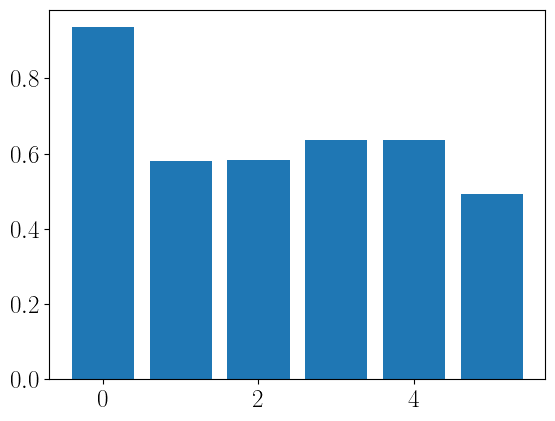

In [143]:
#accuracy bar plot for each category
accuracy = []
for cat in sorted(df["y_true"].round().astype(int).unique()):
    df_cat = df[df["y_true"].round().astype(int) == cat]
    accuracy.append((df_cat["y_true"].round() == df_cat["y_pred"].round()).mean())
plt.bar(sorted(df["y_true"].round().astype(int).unique()), accuracy)

print(accuracy)

In [144]:
from sklearn.metrics import roc_auc_score, root_mean_squared_error, mean_squared_error

Text(0.5, 1.0, 'Mean Squared Error for each week')

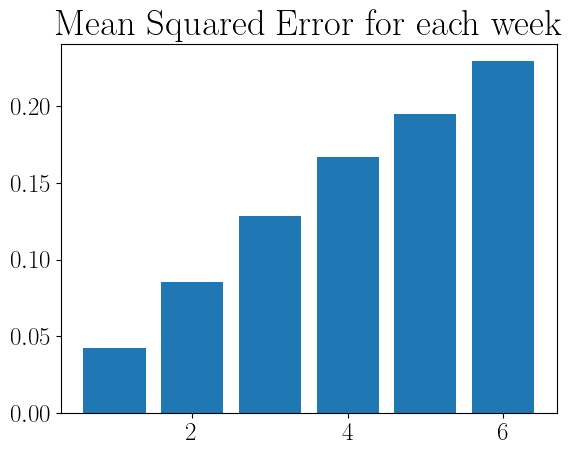

In [145]:
# MAE plot for each week
mse = []
for w in range(6):
    wdf = df[df['week']==w]
    mse.append(mean_squared_error(wdf['y_true'], wdf['y_pred']))
plt.bar(range(1,7), mse)
plt.title("Mean Squared Error for each week")

Text(0.5, 1.0, 'F1 score for each week')

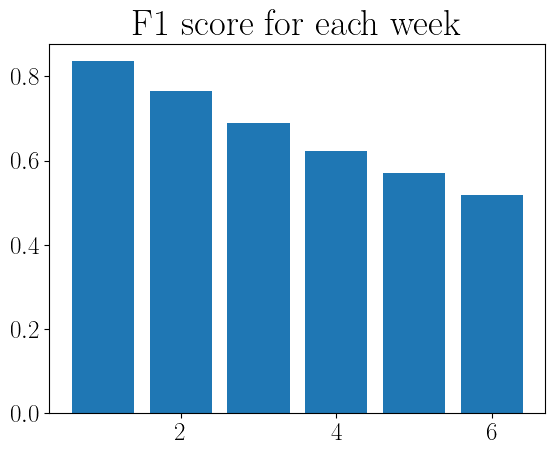

In [146]:
# F1 plot for each week
f1 = []
for w in range(6):
    wdf = df[df['week']==w]
    f1.append(f1_score(wdf['y_true'].round(),wdf['y_pred'].round(), average='macro'))
plt.bar(range(1,7), f1)
plt.title("F1 score for each week")

(array([2.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 5.000e+00,
        2.000e+00, 8.000e+00, 9.000e+00, 2.600e+01, 4.200e+01, 4.700e+01,
        4.500e+01, 6.700e+01, 9.600e+01, 1.680e+02, 2.180e+02, 2.510e+02,
        4.910e+02, 1.561e+03, 5.983e+03, 3.462e+03, 6.150e+02, 4.130e+02,
        3.460e+02, 2.910e+02, 2.040e+02, 1.450e+02, 8.500e+01, 6.200e+01,
        3.200e+01, 1.200e+01, 2.100e+01, 1.200e+01, 8.000e+00, 5.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-3.06343031, -2.91822799, -2.77302568, -2.62782337, -2.48262105,
        -2.33741874, -2.19221642, -2.04701411, -1.90181179, -1.75660948,
        -1.61140716, -1.46620485, -1.32100254, -1.17580022, -1.03059791,
        -0.88539559, -0.74019328, -0.59499096, -0.44978865, -0.30458633,
        -0.15938402, -0.01418171,  0.13102061,  0.27622292,  0.42142524,
         0.56662755,  0.71182987,  0.85703218,  1.0022345 ,  1.14743681,
         1.29263913,  1.43784144,  1.58304375,  1.72824607,  1.8

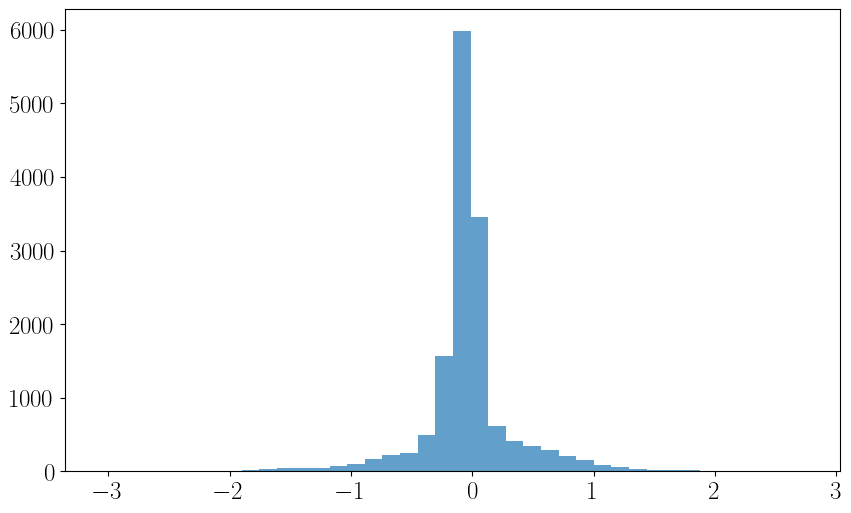

In [147]:
# Error distribution
plt.figure(figsize=(10, 6))
plt.hist(df['y_true'] - df['y_pred'], bins=40, alpha=0.7, label='error')

Text(0, 0.5, 'Residuals')

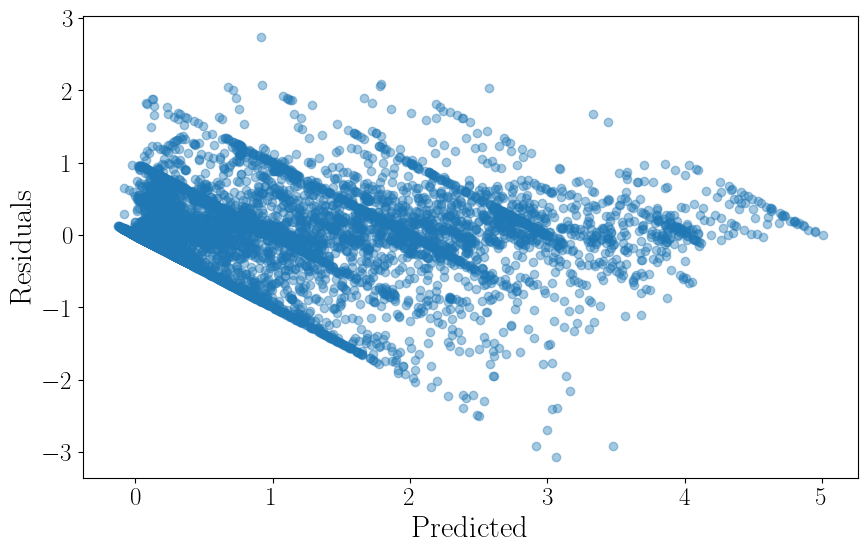

In [148]:
# predicted values vs residuals
plt.figure(figsize=(10, 6))
plt.scatter(df['y_pred'], df['y_true'] - df['y_pred'], alpha=0.4)
plt.xlabel("Predicted")
plt.ylabel("Residuals")

Text(0, 0.5, 'True')

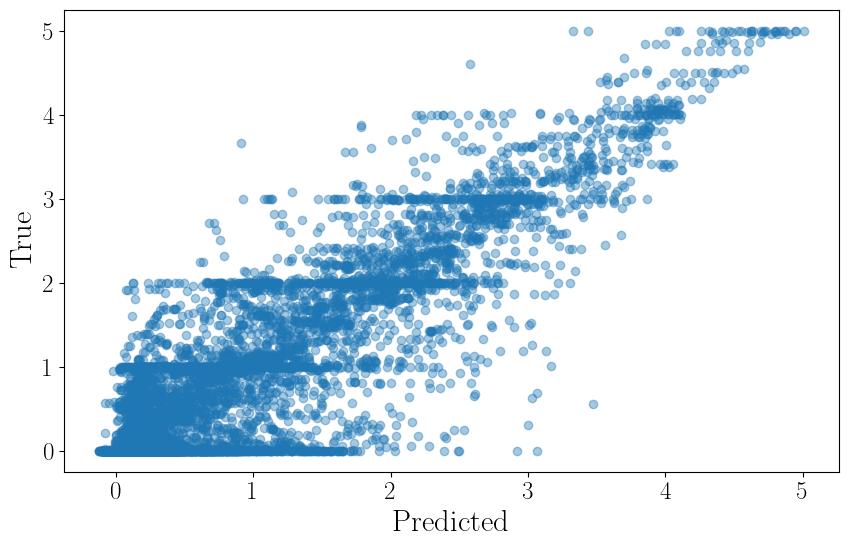

In [149]:
plt.figure(figsize=(10, 6))
plt.scatter(df['y_pred'], df['y_true'], alpha=0.4)
plt.xlabel("Predicted")
plt.ylabel("True")

In [150]:
fips = []
embeddings_all = []
cat_data_all = []
target_all = []
# On extrait les embebbings sur l'ensemble de test
model.eval()
with torch.no_grad():
    for x, static, catego ,y in tqdm(
    valid_loader, # ou test_loader
    desc="validation predictions...",
    ):
        val_h = tuple([each.data.to(device) for each in model.init_hidden(len(x))])
        x, static, cat, y = x.to(device), static.to(device), catego.to(device), y.to(device)
        print(cat.shape)
        print(x.shape)
        # On obtient les embebbings pour chaque batch
        embeddings = [emb(cat[:, i]) for i, emb in enumerate(model.embeddings)]
        x_cat = torch.cat(embeddings, dim=1)
        fips.append(static[:,14].cpu().numpy())
        embeddings_all.append(x_cat.cpu().numpy())
        cat_data_all.append(cat.cpu().numpy())
        target_all.append(y.cpu().numpy())
# Finalment on concatène les embebbings de tous les batchs
fips = np.concatenate(fips)
embeddings_all = np.concatenate(embeddings_all)
cat_data_all = np.concatenate(cat_data_all)
target_all = np.concatenate(target_all)
print(embeddings_all.shape, cat_data_all.shape, target_all.shape)

validation predictions...: 100%|██████████| 20/20 [00:00<00:00, 345.70it/s]

torch.Size([128, 7])
torch.Size([128, 180, 40])
torch.Size([128, 7])
torch.Size([128, 180, 40])
torch.Size([128, 7])
torch.Size([128, 180, 40])
torch.Size([128, 7])
torch.Size([128, 180, 40])
torch.Size([128, 7])
torch.Size([128, 180, 40])
torch.Size([128, 7])
torch.Size([128, 180, 40])
torch.Size([128, 7])
torch.Size([128, 180, 40])
torch.Size([128, 7])
torch.Size([128, 180, 40])
torch.Size([128, 7])
torch.Size([128, 180, 40])
torch.Size([128, 7])
torch.Size([128, 180, 40])
torch.Size([128, 7])
torch.Size([128, 180, 40])
torch.Size([128, 7])
torch.Size([128, 180, 40])
torch.Size([128, 7])
torch.Size([128, 180, 40])
torch.Size([128, 7])
torch.Size([128, 180, 40])
torch.Size([128, 7])
torch.Size([128, 180, 40])
torch.Size([128, 7])
torch.Size([128, 180, 40])
torch.Size([128, 7])
torch.Size([128, 180, 40])
torch.Size([128, 7])
torch.Size([128, 180, 40])
torch.Size([128, 7])
torch.Size([128, 180, 40])
torch.Size([25, 7])
torch.Size([25, 180, 40])
(2457, 21) (2457, 7) (2457, 6)


In [151]:
df_embed = pd.DataFrame(embeddings_all)

In [152]:
target = pd.DataFrame(target_all, columns=[f"week_{i}" for i in range(1, 7)])

In [153]:
target = target.round().astype(int)

In [154]:
target

,week_1,week_2,week_3,week_4,week_5,week_6
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,1,0,0
3,0,1,0,0,0,0
4,1,1,1,0,0,0
...,...,...,...,...,...,...
2452,0,0,0,0,0,0
2453,0,0,0,0,0,0
2454,2,2,2,2,2,2
2455,1,1,2,2,2,2


In [155]:
df_embed

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-1.596467,1.783186,-0.476386,-0.360118,-0.912851,-0.650274,0.049646,0.721656,-0.710966,-0.167162,...,1.010444,-1.091593,0.96421,-0.306788,0.320337,-0.812735,1.660842,1.459417,0.168551,-0.714791
1,0.089520,-2.312125,-0.213711,0.084666,0.526866,0.346204,0.049646,0.721656,-0.710966,-1.428454,...,0.270090,-1.091593,0.96421,-0.306788,0.320337,-0.812735,1.660842,-0.867133,-0.032177,-0.352501
2,0.089520,-2.312125,-0.213711,0.084666,0.526866,0.346204,0.049646,0.721656,-0.710966,-0.167162,...,1.010444,-1.091593,0.96421,-0.306788,0.320337,-0.812735,1.660842,-0.867133,-0.032177,-0.352501
3,0.089520,-2.312125,-0.213711,0.084666,0.526866,0.346204,0.049646,0.721656,-0.710966,-0.167162,...,1.010444,-1.091593,0.96421,-0.306788,0.320337,-0.812735,1.660842,-0.867133,-0.032177,-0.352501
4,0.089520,-2.312125,-0.213711,0.084666,0.526866,0.346204,0.049646,0.721656,-0.710966,-0.167162,...,1.010444,-1.091593,0.96421,-0.306788,0.320337,-0.812735,1.660842,-0.867133,-0.032177,-0.352501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2452,-1.596467,1.783186,-0.476386,-0.360118,-0.912851,-0.650274,0.049646,0.721656,-0.710966,-0.167162,...,1.010444,-1.091593,0.96421,-0.306788,0.320337,-0.812735,1.660842,-0.867133,-0.032177,-0.352501
2453,-1.596467,1.783186,-0.476386,-0.360118,-0.912851,-0.650274,0.049646,0.721656,-0.710966,-0.167162,...,1.010444,-1.091593,0.96421,-0.306788,0.320337,-0.812735,1.660842,-0.867133,-0.032177,-0.352501
2454,-1.596467,1.783186,-0.476386,-0.360118,-0.912851,-0.650274,0.584466,-0.882023,0.405683,-0.167162,...,1.010444,-1.091593,0.96421,-0.306788,0.320337,-0.812735,1.660842,0.854953,0.517615,0.832782
2455,-1.596467,1.783186,-0.476386,-0.360118,-0.912851,-0.650274,-0.598518,0.948943,-0.311691,-0.167162,...,1.010444,-1.091593,0.96421,-0.306788,0.320337,-0.812735,1.660842,1.459417,0.168551,-0.714791


In [156]:
cat_data = pd.DataFrame(cat_data_all, columns=[f"SQ{i+1}" for i in range(cat_data_all.shape[1])])

In [157]:
# invert the normalization for fips
fips = scaler_dict_static[14].inverse_transform(fips.reshape(-1, 1)).reshape(-1)

In [158]:
fips = pd.DataFrame(fips, columns=["fips"])

In [159]:
fips.to_csv("fips.csv")

In [160]:
cat_data

,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
0,1,1,1,1,1,1,2
1,3,2,1,2,1,1,1
2,3,2,1,1,1,1,1
3,3,2,1,1,1,1,1
4,3,2,1,1,1,1,1
...,...,...,...,...,...,...,...
2452,1,1,1,1,1,1,1
2453,1,1,1,1,1,1,1
2454,1,1,3,1,1,1,3
2455,1,1,2,1,1,1,2


In [161]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=110, random_state=42, verbose = 1)
X_embedded = tsne.fit_transform(df_embed)

[t-SNE] Computing 331 nearest neighbors...
[t-SNE] Indexed 2457 samples in 0.001s...
[t-SNE] Computed neighbors for 2457 samples in 0.078s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2457
[t-SNE] Computed conditional probabilities for sample 2000 / 2457
[t-SNE] Computed conditional probabilities for sample 2457 / 2457
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 38.454987
[t-SNE] KL divergence after 1000 iterations: -0.705136


In [162]:
num_colors = len(cat_data["SQ1"].unique())
color_map_25 = plt.cm.tab20(np.linspace(0, 1, num_colors))
from matplotlib.colors import ListedColormap
color_map_25 = ListedColormap(color_map_25)

In [163]:
import matplotlib.pyplot as plt
import matplotlib as mlp

mlp.rc('font', **{'family':'serif', 'serif':['Computer Modern Roman']})
params = {'backend': 'pdf',
          'axes.labelsize': 22,
          'font.size': 22,
          'legend.fontsize': 16,
          'xtick.labelsize': 18,
          'ytick.labelsize': 18,
          'text.usetex': True,
          'axes.unicode_minus': True}
mlp.rcParams.update(params)

In [164]:
np.sort(cat_data["SQ1"].unique())

array([0, 1, 2, 3, 4, 5, 6])

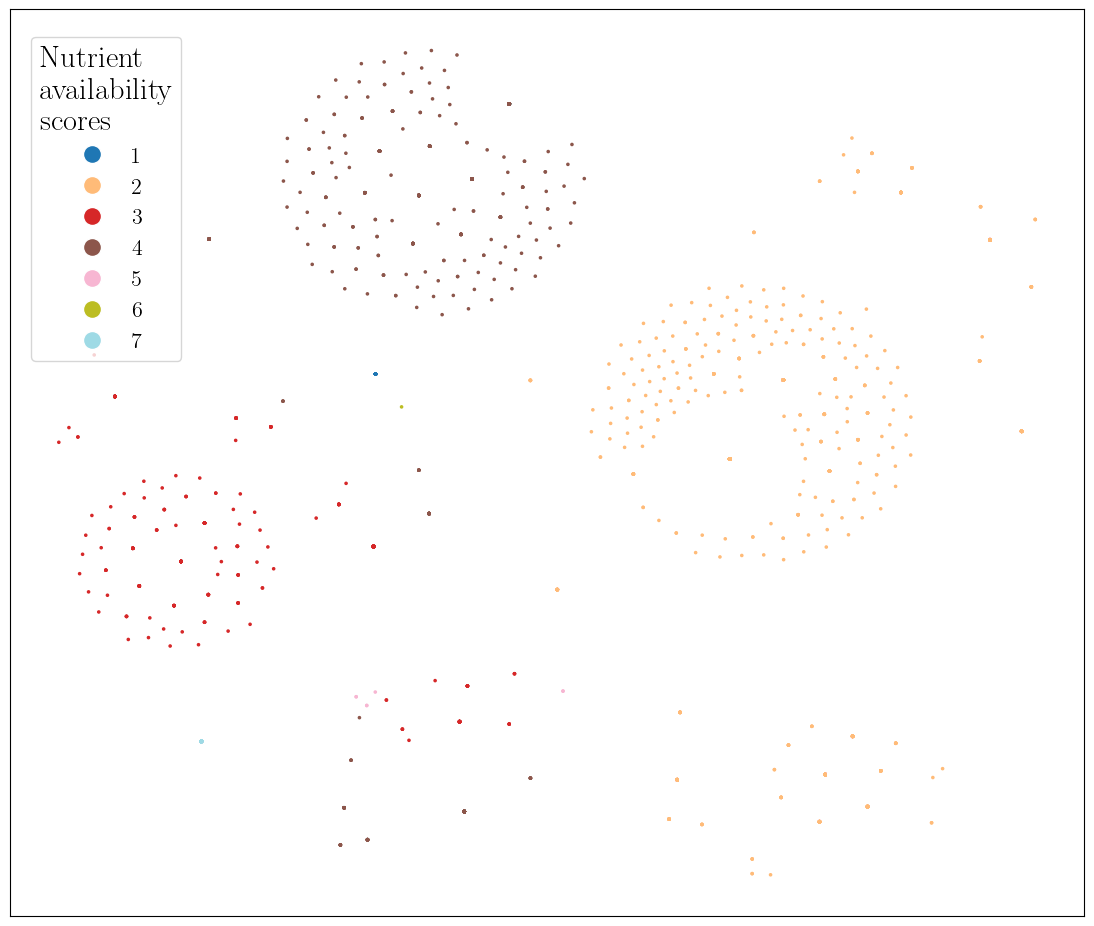

In [165]:
plt.figure(figsize=(11.5, 10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], label='Other Clusters', c=cat_data["SQ1"], cmap=color_map_25, s=2.5)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map_25(i), markersize=13) for i in range(num_colors)]
plt.legend(bbox_to_anchor=(0.17, 0.6), handles=handles, labels=[i+1 for i in list(np.sort(cat_data["SQ1"].unique()))], title = "Nutrient \n availability \n scores")
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig("../results/t-SNE_plot.pdf")

In [166]:
attention_all = []
cat_data_all = []
num_data_all = []
target_all = []
# Evaluar el modelo en el conjunto de prueba
model.eval()
with torch.no_grad():
    for x, static, catego ,y in tqdm(
    valid_loader, # ou test_loader
    desc="validation predictions...",
    ):
        val_h = tuple([each.data.to(device) for each in model.init_hidden(len(x))])
        x, static, cat, y = x.to(device), static.to(device), catego.to(device), y.to(device)
        # Obtener los pesos de atención
        x = x.to(dtype=torch.float32)
        lstm_out, _ = model.lstm(x, val_h)
        attention_weights = torch.softmax(model.attention(lstm_out), dim=1)

        attention_all.append(attention_weights.cpu().numpy())
        cat_data_all.append(cat.cpu().numpy())
        num_data_all.append(static.cpu().numpy())
        target_all.append(y.cpu().numpy())

attention_all = np.concatenate(attention_all)
cat_data_all = np.concatenate(cat_data_all)
num_data_all = np.concatenate(num_data_all)
target_all = np.concatenate(target_all)

validation predictions...: 100%|██████████| 20/20 [00:04<00:00,  4.82it/s]


In [167]:
unique_attentions = np.unique(attention_all, axis=0)
print(unique_attentions.shape)

(2455, 180, 1)


In [168]:
attention_all.shape

(2457, 180, 1)

In [169]:
attention_all = attention_all.reshape(-1, attention_all.shape[-2])

In [170]:
attention_all = attention_all.transpose()

In [171]:
att = pd.DataFrame(attention_all).reset_index(drop=False)

In [172]:
att =att.melt(id_vars='index', value_name='attention')

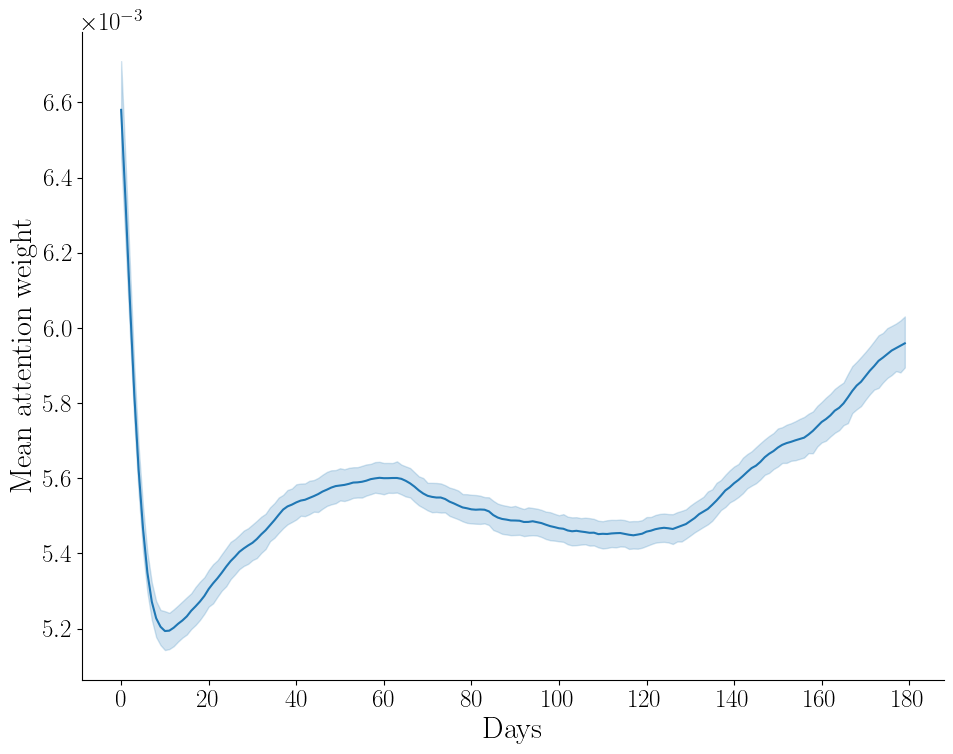

In [173]:
# print the mean attention weights for each day with std using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.lineplot(att, x='index', y='attention')
sns.despine()
plt.xlabel("Days")
plt.xticks(range(0, 181, 20))
# change style of y-axis to scientific notation
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.ylabel("Mean attention weight")
plt.tight_layout()
plt.savefig("../results/attention_weights.pdf")

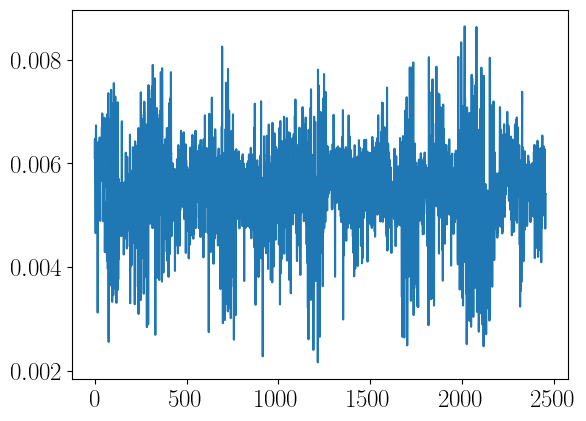

In [174]:
plt.plot(attention_all[101])

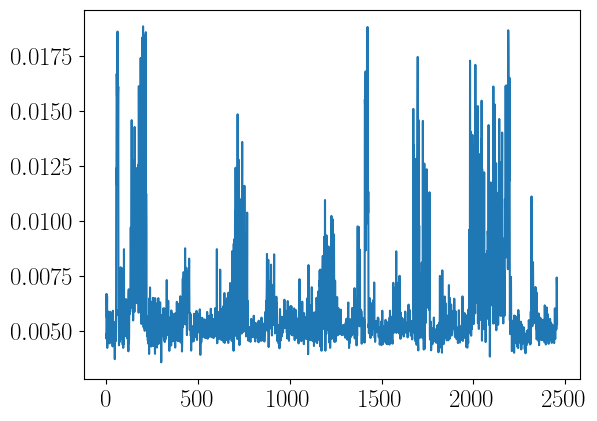

In [175]:
plt.plot(attention_all[2])

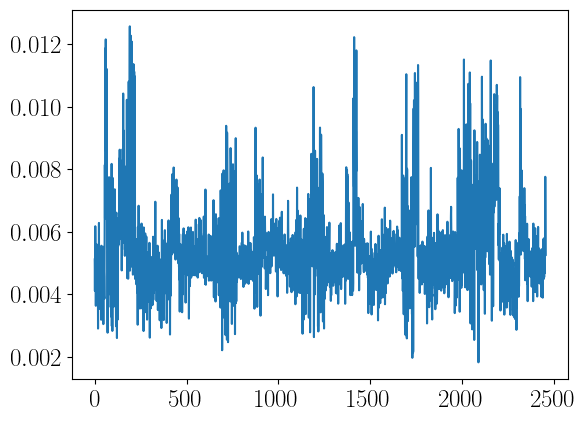

In [176]:
plt.plot(attention_all[5])